# Team performance as a function of FIFA 2015 Attributes
<i>By Diego Ramallo</i>

In this notebook, I'll be looking at data from the Kaggle European Soccer Database: https://www.kaggle.com/hugomathien/soccer 

<img src="https://pixabay.com/static/uploads/photo/2014/03/18/20/21/man-290186_1280.jpg" alt="Drawing" style="width: 600px;"/>

[comment]: <> (Open source image: https://pixabay.com/en/man-fan-person-football-soccer-290186/)

In [1]:
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them
import sqlite3#Used to access database
import pandas as pd#Used to load data as dataframes
import numpy as np#Used for math and array operations
import matplotlib.pyplot as plt#Used for plotting
import seaborn as sns#Also used for plotting, friendly with dataframes

## Feature Engineering with SQL

One thing that I've always wondered about the FIFA games series is how accurate their team metrics are compared to soccer in real life. Thus, I decided to find what attributes have are the best predictors for team performance (winning percentage). In addition, I'll load the team name labels from the teams table for visualization.

In [2]:
#Create connection to SQLite database
con= sqlite3.connect('fifa_data.sqlite')

#Use pandas to query database
data= pd.read_sql_query('''

select team_record.*, team_attributes.*
from (
select team, sum(goals_for) as total_goals_for, sum(goals_against) as total_goals_against, sum(win) as total_wins, sum(loss) as total_losses, sum(draw) as total_draws
from (select *,
	CASE WHEN diff <0 THEN 1 ELSE 0 END as loss, 
	CASE WHEN diff = 0 THEN 1 ELSE 0 END as draw,
	CASE WHEN diff > 0 THEN 1 ELSE 0 END as win 

from (select date, home_team_api_id as team, home_team_goal as goals_for, away_team_goal as goals_against, home_team_goal-away_team_goal as diff 
from Match
UNION
select date, away_team_api_id as team, away_team_goal as goals_for, home_team_goal as goals_against, away_team_goal-home_team_goal as diff 
from Match
order by team) 
)

group by team) team_record
join team_attributes
on team_record.team = team_attributes.team_api_id
where date > 2015
order by team

''',con)

#Load team names
team_names= pd.read_sql_query('''SELECT team_api_id as team, team_long_name FROM Team''', con)

In [3]:
data.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,id,team_fifa_api_id,team_api_id,date,...,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1601,280,292,92,91,57,1300,874,1601,2015-08-28 00:00:00,...,36,Normal,Organised,46,Medium,44,Balanced,64,Normal,Cover
1,1773,126,162,22,40,28,1100,100087,1773,2015-08-28 00:00:00,...,54,Normal,Organised,43,Medium,44,Balanced,50,Normal,Cover
2,1957,287,315,87,89,64,740,110745,1957,2015-08-28 00:00:00,...,66,Normal,Organised,53,Medium,62,Fast,44,Normal,Cover


In [4]:
#Can't use PCA with categorical data so let's remove the columns that have non-numeric data and keep the team names
dataNum= data._get_numeric_data()

In [5]:
print dataNum.shape
dataNum.dtypes

(241, 17)


team                      int64
total_goals_for           int64
total_goals_against       int64
total_wins                int64
total_losses              int64
total_draws               int64
id                        int64
team_fifa_api_id          int64
team_api_id               int64
buildUpPlaySpeed          int64
buildUpPlayDribbling      int64
buildUpPlayPassing        int64
chanceCreationPassing     int64
chanceCreationCrossing    int64
defencePressure           int64
defenceAggression         int64
defenceTeamWidth          int64
dtype: object

In [6]:
dataNum= dataNum.drop(['id','team_fifa_api_id','team_api_id'], axis=1)
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44


The last thing we want to add is a win percentage. However, since we have draws, I'll account for them as half a win. Thus, win percentage will be (total_wins+0.5*total_draws)/(total_wins+total_losses+total_draws). See reference here: https://en.wikipedia.org/wiki/Winning_percentage

In [7]:
dataNum['win_pctg'] = (dataNum['total_wins']+0.5*dataNum['total_draws'])/(dataNum['total_wins']+dataNum[
        'total_losses']+dataNum['total_draws'])

In [8]:
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64,0.502083
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50,0.400000
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44,0.495833


In [9]:
dataNum.describe()

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
count,241.00000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.00000,241.000000,241.000000,241.000000,241.000000
mean,12865.40249,266.622407,256.095436,74.228216,69.373444,48.792531,53.560166,48.178423,50.431535,51.634855,51.53112,46.614108,49.896266,52.190871,0.472854
std,28141.11618,173.367873,118.920366,52.526281,32.824812,24.509150,8.646140,9.118966,9.435553,9.428650,10.36340,9.468173,8.744142,8.208537,0.121250
min,1601.00000,22.000000,38.000000,3.000000,13.000000,4.000000,30.000000,27.000000,30.000000,29.000000,23.00000,25.000000,29.000000,29.000000,0.210526
25%,8388.00000,118.000000,162.000000,27.000000,43.000000,29.000000,48.000000,41.000000,44.000000,47.000000,46.00000,40.000000,44.000000,48.000000,0.400000
50%,8658.00000,247.000000,272.000000,69.000000,71.000000,53.000000,54.000000,48.000000,51.000000,52.000000,52.00000,46.000000,49.000000,52.000000,0.447368
75%,9885.00000,390.000000,346.000000,107.000000,96.000000,69.000000,60.000000,55.000000,56.000000,58.000000,59.00000,53.000000,57.000000,58.000000,0.525735
max,274581.00000,849.000000,471.000000,234.000000,142.000000,100.000000,73.000000,70.000000,76.000000,75.000000,80.00000,72.000000,72.000000,69.000000,0.840461


Great, they're all numeric so sklearn should be able to handle it. Now let's see what the statistics look like for each column to see if anything fishy/interesting pops out.

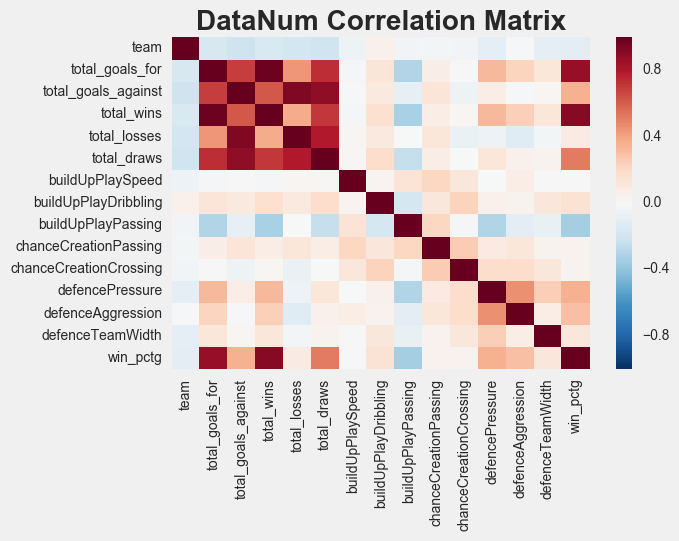

In [156]:
sns.heatmap(dataNum.corr())#, cmap= 'viridis')
#plt.colorbar(label='Pearson Corr. Coeff.')
plt.title('DataNum Correlation Matrix', fontweight= 'bold')

## PCA

In [155]:
from sklearn import preprocessing

feats= dataNum.ix[:, dataNum.columns != 'team']
feats= feats.ix[:, feats.columns != 'win_pctg']
target= dataNum['win_pctg']

featsScaled= preprocessing.scale(feats)

In [12]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9)
pca.fit(featsScaled)

#After ranking the features by the magnitude of their eigenvalues (larger= lar)
pcaFeats = pca.transform(featsScaled)

In [13]:
print 'Number of features before feature reduction: ', featsScaled.shape
print 'Number of features after feature reduction: ', pcaFeats.shape

Number of features before feature reduction:  (241, 13)
Number of features after feature reduction:  (241, 8)


## Visualizing Data

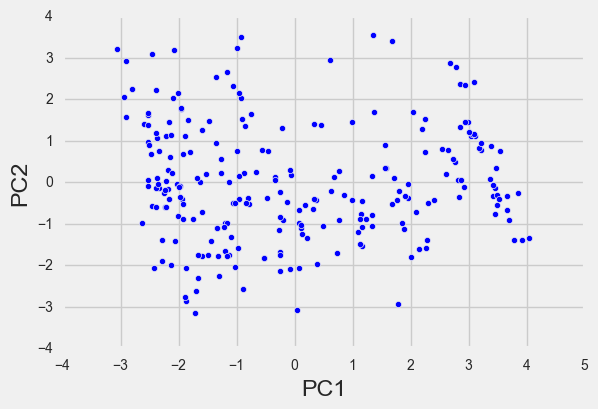

In [157]:
plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [15]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(pcaFeats) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [16]:
print k_means.labels_, len(k_means.labels_)

[0 1 2 2 2 1 1 1 1 1 0 1 1 1 0 2 1 0 1 0 1 2 1 0 0 1 2 0 0 1 0 1 1 0 0 2 1
 1 1 0 2 1 0 1 2 1 1 2 0 1 0 2 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1
 2 1 2 1 0 0 1 0 2 0 1 2 1 2 2 1 1 0 1 2 2 0 1 1 0 1 2 1 2 2 0 2 1 2 0 1 2
 2 2 2 2 2 1 2 0 1 1 0 0 1 2 2 0 1 2 0 2 2 0 1 1 2 2 2 2 1 0 0 2 0 0 1 0 0
 0 0 1 2 1 2 1 0 2 1 0 1 1 2 0 2 0 0 1 2 0 0 1 0 0 2 2 1 1 0 1 0 2 1 0 2 2
 0 1 1 1 2 0 2 0 2 2 1 0 0 2 2 0 1 0 0 0 1 2 2 0 2 2 0 2 2 0 2 0 0 1 0 2 0
 0 0 1 2 0 0 2 0 0 0 2 1 2 2 1 1 1 1 1] 241


Now let's copy our dataNum table and then join the team_names to it so we can keep track of the indices when we visualize our plots.

In [17]:
datanumLabels= dataNum.copy()
datanumLabels= pd.merge(datanumLabels, team_names, how='left',on='team')

In [217]:
datanumLabels[datanumLabels['team_long_name']== 'Rayo Vallecano']

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg,team_long_name
57,8370,247,360,66,96,28,35,52,53,44,47,54,52,63,0.421053,Rayo Vallecano


We'll also try to see how the grouping corresponds to several obvious parameters: win percentage, total wins, total goals, goal chance creation crossing. Th last one is included since it's the Fifa '15 parameter with the largest standard deviation and would be better at showing differences than other parameters.

In [87]:
win_pctg= 120*(datanumLabels['win_pctg'].values)/float(max(datanumLabels['win_pctg'].values))
total_wins= 120*(datanumLabels['total_wins'].values)/float(max(datanumLabels['total_wins'].values))
total_goals_for= 120*(datanumLabels['total_goals_for'].values)/float(max(datanumLabels['total_goals_for'].values))
chanceCreationCrossing= 120*(datanumLabels['chanceCreationCrossing'].values)/float(max(datanumLabels['chanceCreationCrossing'].values))
team_names= datanumLabels['team_long_name'].values

In [21]:
cluster0= []; indexCluster0= []
cluster1= []; indexCluster1= []
cluster2= []; indexCluster2= []

for i in range(0,len(k_means.labels_)):
    if k_means.labels_[i] == 0: 
        cluster0.append(pcaFeats[i,:])
        indexCluster0.append(i)
    elif k_means.labels_[i] == 1: 
        cluster1.append(pcaFeats[i,:])
        indexCluster1.append(i)
    elif k_means.labels_[i] == 2: 
        cluster2.append(pcaFeats[i,:])
        indexCluster2.append(i)

In [22]:
cluster0= np.array(cluster0)
cluster1= np.array(cluster1)
cluster2= np.array(cluster2)

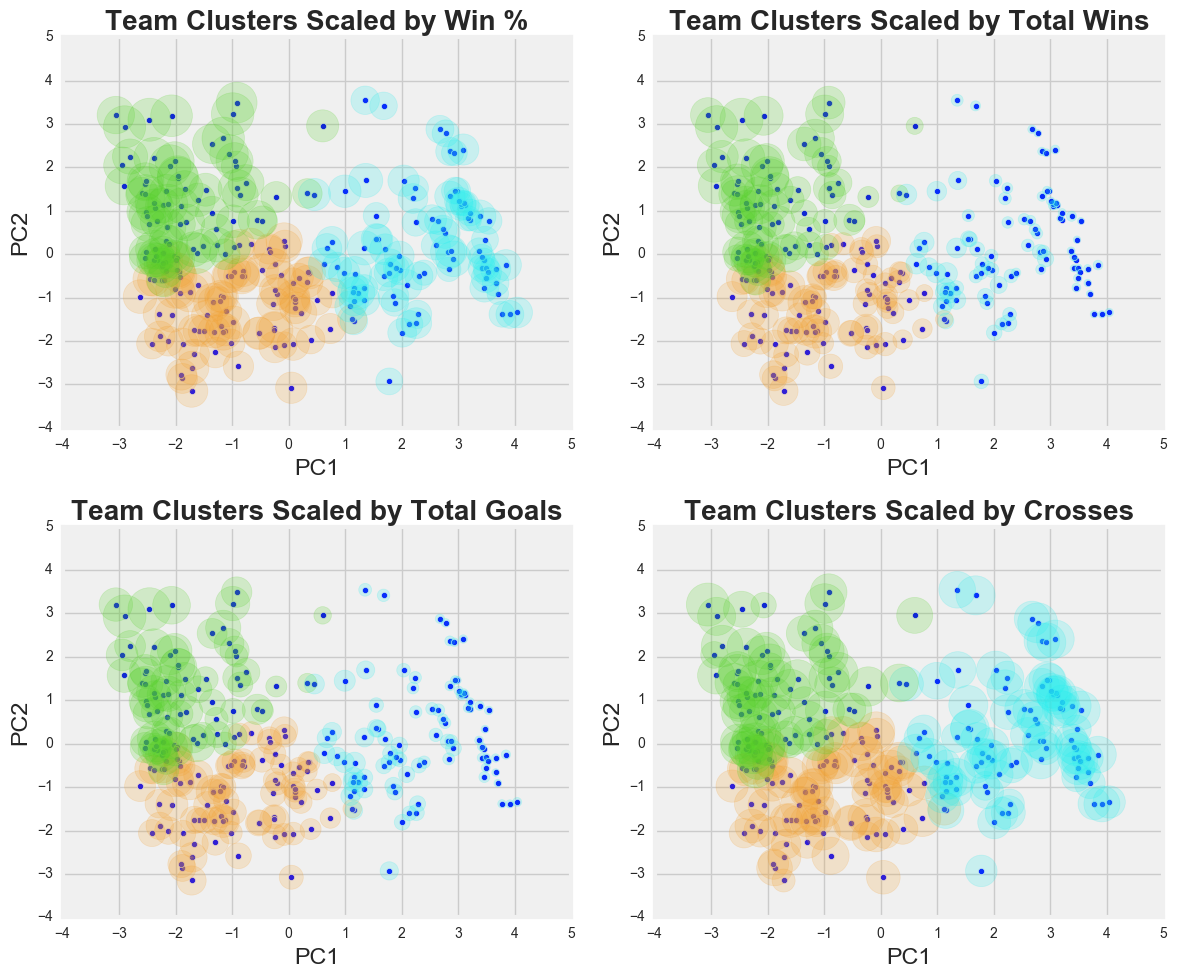

In [154]:
%matplotlib inline

clusters= [cluster0, cluster1, cluster2]
scales= [win_pctg, total_wins, total_goals_for, chanceCreationCrossing]
titles= ['Team Clusters Scaled by Win %', 'Team Clusters Scaled by Total Wins',
         'Team Clusters Scaled by Total Goals', 'Team Clusters Scaled by Crosses']


plotIndices= [[2,2,1],[2,2,2],[2,2,3],[2,2,4]]

figure, ax = plt.subplots(1,1, figsize=(12,10))

for i in range(4):
    plt.style.use('fivethirtyeight')
    plt.subplot(2, 2, i+1)
    plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.scatter(cluster0[:,0], cluster0[:,1], color= '#f2a02e', s= scales[i][indexCluster0]*8, alpha= 0.2) 
    plt.scatter(cluster1[:,0], cluster1[:,1], color= '#28eded', s= scales[i][indexCluster1]*8, alpha= 0.2)
    plt.scatter(cluster2[:,0], cluster2[:,1], color= '#54d127', s= scales[i][indexCluster2]*8, alpha= 0.2)
    
    plt.title(titles[i], fontweight= 'bold')
plt.tight_layout()

In [151]:
print 'Cluster 0, Cluster 1, Cluster 2'
zip(datanumLabels.ix[indexCluster0].sort('total_goals_for', ascending= False).head(5)['team_long_name'],
datanumLabels.ix[indexCluster1].sort('total_goals_for', ascending= False).head(5)['team_long_name'], 
    datanumLabels.ix[indexCluster2].sort('total_goals_for', ascending= False).head(5)['team_long_name'])

Cluster 0, Cluster 1, Cluster 2


[(u'Manchester City', u'Southampton', u'FC Barcelona'),
 (u'Chelsea', u'PEC Zwolle', u'Real Madrid CF'),
 (u'FC Twente', u'FC Augsburg', u'Celtic'),
 (u'Feyenoord', u'Ross County FC', u'FC Bayern Munich'),
 (u'SC Heerenveen', u'RC Celta de Vigo', u'PSV')]

This is interesting, two of the clusters contain some world class teams (Southhampton is good but maybe not at that level). What seems to connect these?

In [252]:
#Extra interactive Bokeh Figure

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter

output_notebook()

#We'll now make the source for the info on our hover
source= ColumnDataSource(data= dict(
        x= pcaFeats[:,0], y= pcaFeats[:,1],
        x0= cluster0[:,0], y0= cluster0[:,1],
        x1= cluster1[:,0], y1= cluster1[:,1],
        x2= cluster2[:,0], y2= cluster2[:,1],
        marker_size0= total_goals_for[indexCluster0]/1.5,
        marker_size1= total_goals_for[indexCluster1]/1.5,
        marker_size2= total_goals_for[indexCluster2]/1.5,
        goals= datanumLabels['total_goals_for'].values,
        title= team_names))

hover= HoverTool(tooltips= [("Team", " @title")])#, 
                            #('Goals Scored', ' @goals')])

p = figure(plot_width=800, plot_height=600, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "Clustering of FIFA Soccer Clubs (Scaled by Goals Scored)", title_text_font_size='18pt')

#First plot the thresholded data (to void )
p.circle('x0', 'y0', line_color= '#f2a02e', fill_color= '#f2a02e', fill_alpha= 0.3, source=source,
                           line_width= 4, size= 'marker_size0')
p.circle('x1', 'y1', line_color= '#28eded', fill_color= '#28eded', fill_alpha= 0.3, source=source,
                           line_width= 4, size='marker_size1')
p.circle('x2', 'y2', line_color= '#54d127', fill_color= '#54d127', fill_alpha= 0.3, source=source,
                           line_width= 4, size='marker_size2')

#Main points beneath subclusters
p.circle(pcaFeats[:,0], pcaFeats[:,1], color= 'blue', size=3)

p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.axis_label = "Principal Component 1"
p.yaxis.axis_label = "Principal Compoent 2"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

p.title_text_font_style = "bold"

show(p)

Loading BokehJS ...

Notes here

In [ ]:
#Experimental plot (trying to fix repeat labeling)

#Extra interactive Bokeh Figure

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter

output_notebook()

#We'll now make the source for the info on our hover
source= ColumnDataSource(data= dict(
        x= pcaFeats[:,0], y= pcaFeats[:,1],
        x0= cluster0[:,0], y0= cluster0[:,1],
        x1= cluster1[:,0], y1= cluster1[:,1],
        x2= cluster2[:,0], y2= cluster2[:,1],
        marker_size0= total_goals_for[indexCluster0]/1.5,
        marker_size1= total_goals_for[indexCluster1]/1.5,
        marker_size2= total_goals_for[indexCluster2]/1.5,
        goals= datanumLabels['total_goals_for'].values,
        title= team_names))

source0= ColumnDataSource(data= dict(
        x0= cluster0[:,0], y0= cluster0[:,1],
        marker_size0= total_goals_for[indexCluster0]/1.5,
        ))#goals0= datanumLabels['total_goals_for'].values[indexCluster0],
        #title0= team_names[indexCluster0]))

source1= ColumnDataSource(data= dict(
        x1= cluster1[:,0], y1= cluster1[:,1],
        marker_size1= total_goals_for[indexCluster1]/1.5,
        ))#goals1= datanumLabels['total_goals_for'].values[indexCluster1],
        #title1= team_names[indexCluster1]))

source2= ColumnDataSource(data= dict(
        x2= cluster2[:,0], y2= cluster2[:,1],
        marker_size2= total_goals_for[indexCluster2]/1.5,
        ))#goals2= datanumLabels['total_goals_for'].values[indexCluster2],
        ##title2= team_names[indexCluster2]))

hover= HoverTool(tooltips= [
        
        ("Team", " @title"), ('Goals Scored', ' @goals'), 
        ])

p = figure(plot_width=800, plot_height=600, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "European Team Clusters Scaled by Goals Scored", title_text_font_size='14pt')

#First plot the thresholded data (to void )
p.circle(cluster0[:,0], cluster0[:,1], line_color= '#f2a02e', fill_color= '#f2a02e', fill_alpha= 0.3,# source=source0,
                           line_width= 4, size= total_goals_for[indexCluster0]/1.5)
p.circle(cluster1[:,0], cluster1[:,1],  line_color= '#28eded', fill_color= '#28eded', fill_alpha= 0.3,# source=source1,
                           line_width= 4, size=total_goals_for[indexCluster1]/1.5)
p.circle(cluster2[:,0], cluster2[:,1], line_color= '#54d127', fill_color= '#54d127', fill_alpha= 0.3,# source=source2,
                           line_width= 4, size=total_goals_for[indexCluster1]/1.5)

#p.circle(pcaFeats[:,0], pcaFeats[:,1], color= 'blue', size=3)
p.circle('x','y', color= 'blue', size=3, source= source)


p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.axis_label = "PC1"
p.yaxis.axis_label = "PC2"

p.title_text_font_style = "bold"

show(p)

In [229]:
#Let's see if we can visualize the clusters in terms of rank of goals scored

 (0, 24),

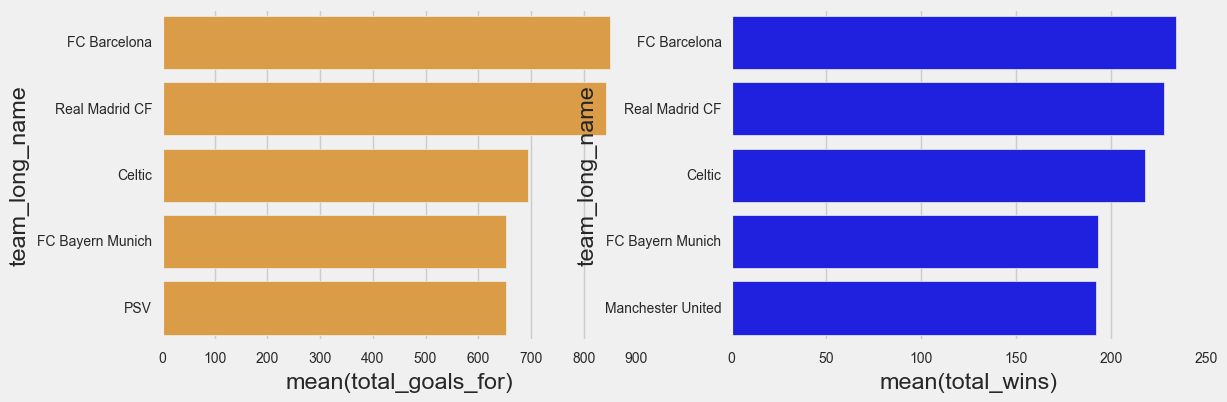

In [149]:
figure, axes = plt.subplots(figsize=(12,4))

plt.subplot(1,2,1)
sns.barplot(x="total_goals_for", y= 'team_long_name', data=datanumLabels.sort('total_goals_for', ascending= False).head(5), color="#f2a02e")

plt.subplot(1,2,2)
sns.barplot(x="total_wins", y= 'team_long_name', data=datanumLabels.sort('total_wins', ascending= False).head(5), color="b")

ax.set(xlim=(0, 24), ylabel="",
       xlabel="Total Goals")
#plt.tight_layout()

Now that we have this taken care of, we can do visualization and any other transformations on the training set without worrying about having observed some of our test/validation set (in case it poisons our analysis in any way).

## Visualizing Data

Let's first look at how far customers have to travel to reach the different shops. Then, we'll determine how distance affects customers spending habits at each store.

### Section

## Section Final